
# tSNE!

In [2]:
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="6"
import sys
sys.path.append(os.path.realpath(".."))
import tools
import EnergyFlow.ef_tools as ef_tools
import numpy as np

with open("../filepath.txt", 'r') as f:
    filename = f.read().strip("\n")   

# load data
if False: #os.path.exists("X.npy"):
    X = np.load("X.npy", allow_pickle=True)
    y = np.load("y.npy", allow_pickle=True)
else:
    X, y = ef_tools.open_file(filename, njets=10)
    np.save("X.npy", X, allow_pickle=True)
    np.save("y.npy", y, allow_pickle=True)

Using TensorFlow backend.


padding arrays
done padding
777150 events total
444528 events after ensuring first 3 are correctly tagged
307055 events after ensuring we only have 3 tags
303931 events after ensuring there is at most 1 untagged jet


Loading model... 
Using architecture: ../models/architecture_2b.json 
and weights: ../models/weights_2b.h5
303931


100%|██████████| 303931/303931 [00:02<00:00, 124148.35it/s]


overall accuracy: 72.35 percent
ignoring 0.0 percent of 303931 events


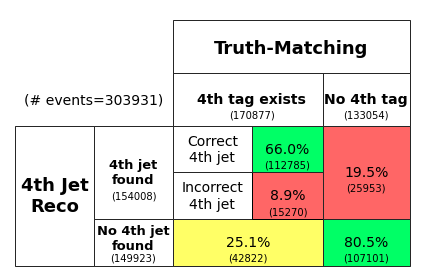

In [5]:
import importlib
import ptetaphi_nn
import awkward
import uproot_methods as urm

importlib.reload(ptetaphi_nn)

events = awkward.Table()
# add data to table
events['resolved_lv'] = urm.TLorentzVectorArray.from_ptetaphie(X[:,:,0], X[:,:,1], X[:,:,2],X[:,:,3])
truths = y[:,:-1].copy().astype(int)
truths[:,:3] = 1 
events['truth'] = truths  # no no-jet jet
tags = X[:,:,4]
events['tag'] = tags

nn = ptetaphi_nn.PtEtaPhiNN(events, load=("../models/architecture_2b.json", "../models/weights_2b.h5"), njets=X.shape[1], print_csv=False)

print(len(events))

selections = nn.evaluate(events, print_csv=False)

In [6]:
from tqdm import tqdm
# get the category of each event:
"""
TABLE WITH CATEGORIES
              _______________
______________| TRUTH       |
| RECO        | Yep  | Nope |
| Yep, good   | 0    | 3    |
| Yep, bad    | 1    |      |
| Nope        | 2    | 4    |
-----------------------------
0 - 4th exists, was correctly selected
1 - 4th exists, incorrect jet selected
2 - 4th exists, no jet selected
3 - 4th does not exist, jet selected incorrectly
4 - 4th does not exist, no jet selected (correctly)
5 - None of the above

"""
# total number of events
n_events = len(truths)

# truths, tags selections are arrays from above,
# categories[i] = 0,1,2,3,4,5 for each event
categories = np.zeros(n_events, dtype=int)

# this loop is almost identical to the one in tools.evaluate_model
for i in tqdm(range(n_events)):
    selection = selections[i]
    truth = truths[i]
    tag = tags[i]

    selection_index = np.where(selection == 1)[0]
    n_selections = len(selection_index)
        
    if n_selections > 1:
        raise ValueError("why are you selecting more than 1?")

    untagged = np.logical_xor(truth, tag).astype(int)

    n_untagged = np.count_nonzero(untagged)

    if n_untagged == 0:  # should not have made any selection
        if n_selections != 0:  # made a selection, should not have
            categories[i] = 3
        else:  # good call, no selection
            categories[i] = 4
    elif n_untagged == 1:  # if we should have made 1 selection
        if n_selections == 0:  # no selection, bad
            categories[i] = 2
        elif n_selections == 1:  # 1 selection, good
            # was it the right jet though?
            right_selection = bool(truth[selection_index] == 1)
            if right_selection:
                categories[i] = 0
            else:
                categories[i] = 1
        else:
            raise ValueError("Why did you select more than 1 jet?")
    else:  # there were 2 or more untagged jets
        categories[i] = 5

print("\r", categories)

100%|██████████| 303931/303931 [00:03<00:00, 99159.89it/s] 

 [4 4 4 ... 0 0 0]


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.003s...
[t-SNE] Computed neighbors for 1000 samples in 0.055s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 73.940964
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.898087
[t-SNE] KL divergence after 31000 iterations: 1.070987
(1000, 2)


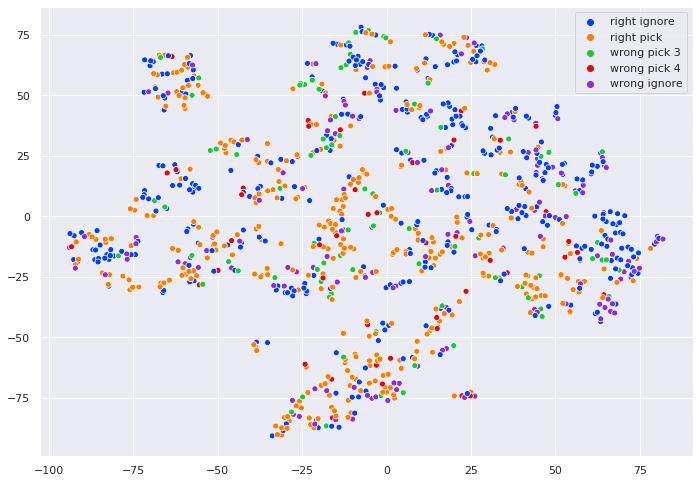

In [16]:
n=1000

import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 5)

tsne = TSNE(perplexity=10, verbose=True, learning_rate=1, n_iter=100000)
# :1000 so this doesn't take eons
x_2d = np.array([x.flatten() for x in X])[:n, :]

X_embedded = tsne.fit_transform(x_2d)
print(X_embedded.shape)


d = {0: "right pick",
    1: "wrong pick 4",
    2: "wrong ignore",
    3: "wrong pick 3",
    4: "right ignore",}
cat_words = np.array([d[c] for c in categories])

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cat_words[:n], legend='full', palette=palette)

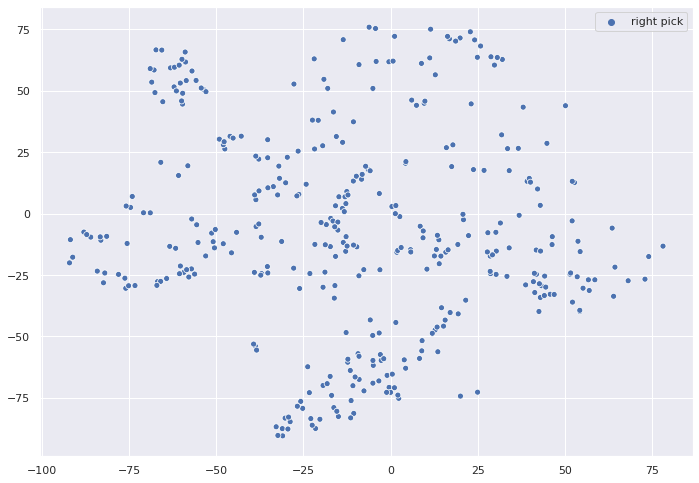

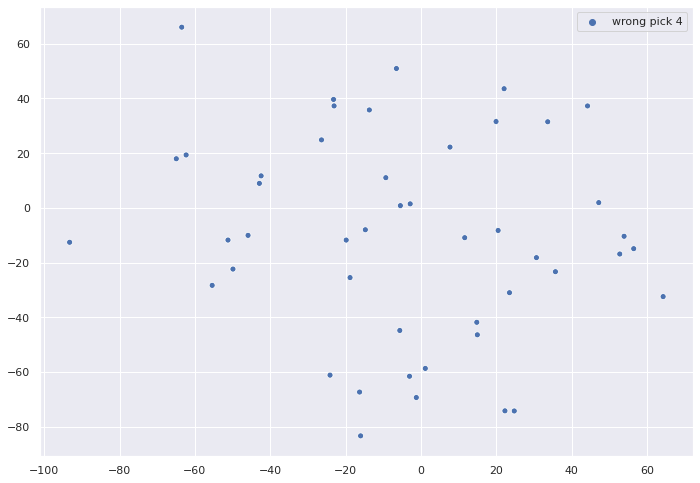

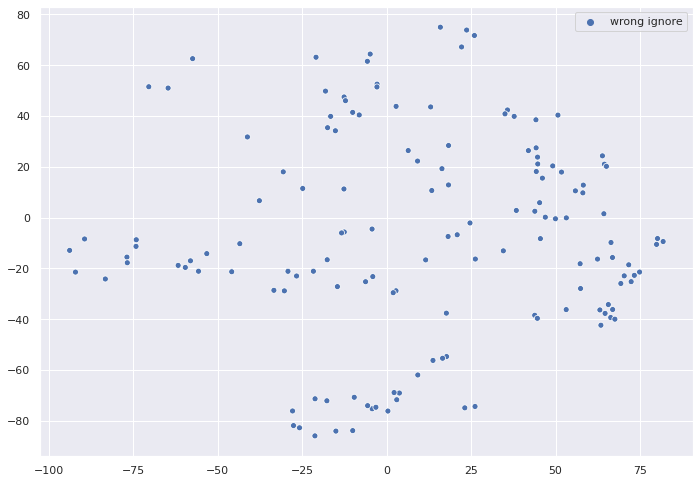

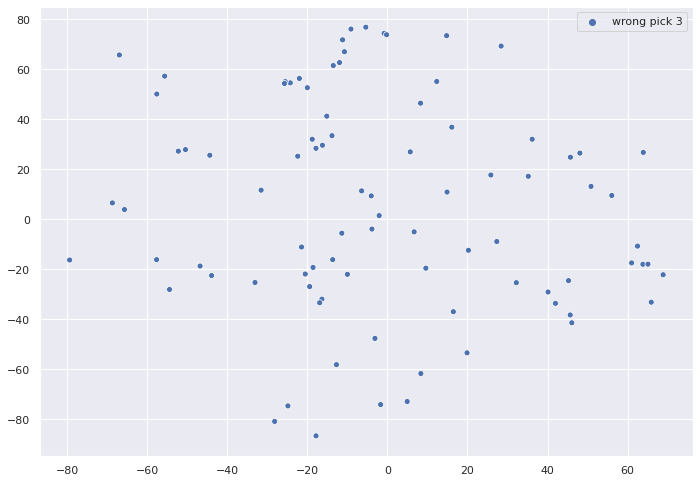

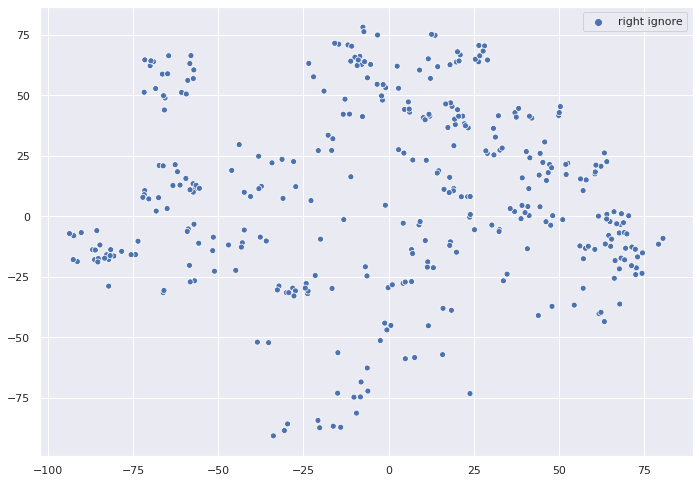

In [17]:
cw = cat_words[:n]
for cword in d.values():
    x0 = X_embedded[cw==cword,0]
    x1 = X_embedded[cw==cword,1]
    c = cw[cw==cword]
    sns.scatterplot(x0, x1, hue=c, legend='full')
    plt.show()